In [1]:
# This Code is to prepare processed images and videos

In [6]:
#pip install opencv-python
#pip install moviepy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from scipy.optimize import curve_fit
from moviepy.editor import VideoFileClip
from IPython.display import HTML
##############################################################################################################################
def UpdatePicture(image):
    def NegLineFit(img, line, vert):
        xCurveDataNeg = np.array([])
        yCurveDataNeg = np.array([])
        for LinesNeg in line:
            for x1,y1,x2,y2 in LinesNeg:
                if ((y2-y1)/(x2-x1)) < 0:
                    #plt.plot([x1, x2], [y1, y2],'*k')
                    xCurveDataNeg = np.concatenate((xCurveDataNeg,np.array([x1, x2])))
                    yCurveDataNeg = np.concatenate((yCurveDataNeg,np.array([y1, y2])))
        xLimNeg = img.shape[1]/2
        SearchIndexNeg = (xCurveDataNeg < xLimNeg) & (xCurveDataNeg > (sum(xCurveDataNeg)/len(xCurveDataNeg))-(xLimNeg/4))
        yCurveDataNeg = yCurveDataNeg[SearchIndexNeg]
        xCurveDataNeg = xCurveDataNeg[SearchIndexNeg]
        #plt.plot(xCurveDataNeg,yCurveDataNeg,'*k')

        def CurveFitFunc(x, a, b):
            return a * x + b
        def CurveFitFuncInv(y, a, b):
            return (y-b) / a

        popt, pcov = curve_fit(CurveFitFunc, xCurveDataNeg, yCurveDataNeg)
        #plt.plot(xCurveDataNeg, CurveFitFunc(xCurveDataNeg, *popt), 'r-',)
        yLimNeg = vert[0][1][1]
        yMax = img.shape[0]
        xStartNeg = CurveFitFuncInv(yMax, *popt)
        xEndNeg = CurveFitFuncInv(yLimNeg, *popt)
        yCurveNeg = CurveFitFunc(np.array([xStartNeg, xEndNeg]), *popt) 
        LineNeg = [xStartNeg,max(yCurveNeg),xEndNeg,min(yCurveNeg)]
        LineNeg = [int(i) for i in LineNeg]
        return LineNeg
    ##############################################################################################################################
    def PosLineFit(img, line, vert):
        xCurveDataPos = np.array([])
        yCurveDataPos = np.array([])
        for LinesPos in line:
            for x1,y1,x2,y2 in LinesPos:
                if ((y2-y1)/(x2-x1)) > 0:
                    #plt.plot([x1, x2], [y1, y2],'*k')
                    xCurveDataPos = np.concatenate((xCurveDataPos,np.array([x1, x2])))
                    yCurveDataPos = np.concatenate((yCurveDataPos,np.array([y1, y2])))
        xLimPos = img.shape[1]/2
        SearchIndexPos = (xCurveDataPos > xLimPos) & (xCurveDataPos < (sum(xCurveDataPos)/len(xCurveDataPos))+(xLimPos/4))
        yCurveDataPos = yCurveDataPos[SearchIndexPos]
        xCurveDataPos = xCurveDataPos[SearchIndexPos]    
        #plt.plot(xCurveDataPos,yCurveDataPos,'*k')

        def CurveFitFunc(x, a, b):
            return a * x + b
        def CurveFitFuncInv(y, a, b):
            return (y-b) / a

        popt, pcov = curve_fit(CurveFitFunc, xCurveDataPos, yCurveDataPos)
        #plt.plot(xCurveDataPos, CurveFitFunc(xCurveDataPos, *popt), 'r-',)
        yLimPos = vert[0][2][1]
        yMax = img.shape[0]
        xStartPos = CurveFitFuncInv(yMax, *popt)
        xEndPos = CurveFitFuncInv(yLimPos, *popt)
        yCurvePos = CurveFitFunc(np.array([xStartPos, xEndPos]), *popt) 
        LinePos = [xStartPos,max(yCurvePos),xEndPos,min(yCurvePos)]
        LinePos = [int(i) for i in LinePos]
        return LinePos
    ##############################################################################################################################
    def draw_lines(img, Hlines, clr, thick, vert):
        lineImg = np.copy(img)*0
        LinesFit = np.array([[NegLineFit(lineImg, Hlines, vert)],[PosLineFit(lineImg, Hlines, vert)]])
        for line in LinesFit:
            for x1,y1,x2,y2 in line:
                cv2.line(lineImg,(x1,y1),(x2,y2),clr,thick)
        #plt.imshow(lineImg)
        #combox = cv2.addWeighted(color_edges, 0.8, lineImg, 1, 0) 
        #plt.imshow(combox)
        return lineImg
    ##############################################################################################################################

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
    plt.imshow(gray, cmap='gray')
    # Define a kernel size for Gaussian smoothing / blurring
    # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

    # Define parameters for Canny and run it
    # NOTE: if you try running this code you might want to change these!
    low_threshold = 50
    high_threshold = 150
    masked_edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(masked_edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    xUpperLeft = 470
    xUpperRight = 490
    yUpper = 315
    vertices = np.array([[(0,imshape[0]),(xUpperLeft, yUpper), (xUpperRight, yUpper), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(masked_edges, mask)

    # Display the image
    #plt.imshow(masked_edges, cmap='Greys_r')

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2
    theta = 1*np.pi/180
    threshold = 15
    min_line_length = 20
    max_line_gap = 25
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    color = [255,0,0]               
    linesx = draw_lines(image, lines, color, 10, vertices)
    #plt.imshow(linesx)
    color.reverse()
    cvlinesx = draw_lines(image, lines, color, 10, vertices)
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

    # Draw the lines on the edge image
    combox = cv2.addWeighted(color_edges, 0.8, linesx, 1, 0) 
    #plt.imshow(combox)

    UpdatedPicture = cv2.addWeighted(image, 1, linesx, 1, 0) 
    UpdatedPictureCV2 = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1, cvlinesx, 1, 0) 
    UpdatedFrame = cv2.addWeighted(image, 1, cvlinesx, 1, 0) 
    #return UpdatedPicture, UpdatedPictureCV2, UpdatedFrame
    return UpdatedPicture
##############################################################################################################################

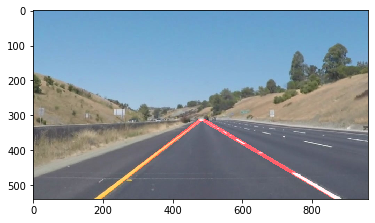

In [7]:
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = mpimg.imread('test_images/solidYellowCurve.jpg')
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
image = mpimg.imread('test_images/solidYellowLeft.jpg')
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
ResultImage = UpdatePicture(image) 
plt.imshow(ResultImage)

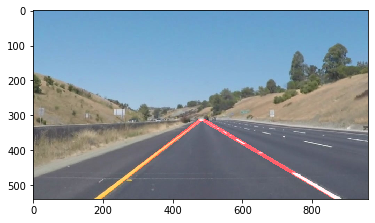

In [12]:
ReadDirectory = 'test_images/'
SaveDirectory = 'test_images_output/'
for file in os.listdir(ReadDirectory): 
    image = mpimg.imread(ReadDirectory+file)
    ResultImage, ResultImageCV2, UpdatedFrame = UpdatePicture(image) 
    cv2.imwrite(SaveDirectory+file, ResultImageCV2)
    #plt.imshow(ResultImage)
    #cv2.imshow('image',ResultImageCV2)
    #cv2.waitKey(0)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

t: 100%|█████████▉| 680/681 [00:21<00:00, 33.47it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 22.3 s


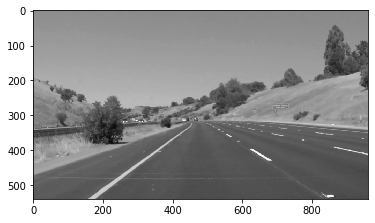

In [4]:
#white_output = 'test_videos_output/solidWhiteRight.mp4'
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_output = 'test_videos_output/solidYellowLeft.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
white_clip = clip1.fl_image(UpdatePicture)
%time white_clip.write_videofile(white_output, audio=False)